# Plain vs. Skip Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL
import glob

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [15]:
def myimgshow(plt,img,plot_size = (4,4)):
    plt.gray()
    plt.rcParams["figure.figsize"] = plot_size
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

In [3]:
def load_data(path,img_name=None,black_list=[]):
    # path: directory of images
    # img_name: a specific image
    # black_list: images that are not desired for processing
    
    if img_name is None:
        img_np_list = []
        for filename in glob.glob(path+"/*"):
            if filename not in black_list:
                img=Image.open(filename)
                img_np_list.append(img)
        img_var_list = []
        for i,img in enumerate(img_np_list):
            img_np_list[i] = np.array([pil_to_np(img)[0]])
            img_np_list[i] = img_np_list[i] / np.max(img_np_list[i])
            img_var_list.append(np_to_var(img_np_list[i]).type(dtype))
        return img_np_list,img_var_list
    else:
        img_path = path + "/" + img_name
        img_pil = Image.open(img_path)
        img_np = np.array([pil_to_np(img_pil)[0]])
        img_np = img_np / np.max(img_np)
        img_var = np_to_var(img_np).type(dtype)
        return img_np,img_var

## Load image(s)

In [4]:
path = "./test_data"
img_name = "brain_sagittal.jpg"
#ps = ".jpg"
single_image = False # this flag determines whether the analysis is needed for one image or a group of images

In [5]:
img_np_list,img_var_list = load_data(path,black_list=[path+"/"+img_name])
img_np,img_var = load_data(path,img_name)

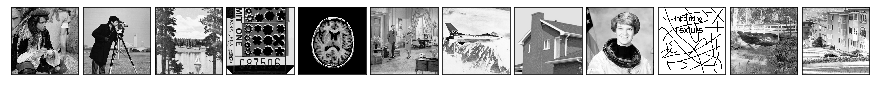

In [6]:
if single_image:
    myimgshow(plt,img_np)
    plt.axis("off")
    plt.show()
else:
    plot_image_grid([img[0] for img in img_np_list],nrows=1)
    plt.show()    

In [7]:
if single_image:
    data_np = [img_np]
    data_var = [img_var]
else:
    data_np = img_np_list
    data_var = img_var_list

## Define network ant train it

In [13]:
output_depth = [img.shape[0] for img in data_np]
num_channels = 140
num_layers = 6
maxv = [np.max(img) for img in data_np]
in_size = [32,32]
out_size = [img[0].shape for img in data_np]

rnd = 500
numit = 20000
rn = 0.001
LR = 0.01

skip_psnr = np.zeros(len(data_np))
plain_psnr = np.zeros(len(data_np))

for i,img in enumerate(data_var):
    
    skipnet = skipdecoder(out_size[i],in_size,output_depth[i],num_layers,num_channels,skips=True).type(dtype)
    
    plainnet = skipdecoder(out_size[i],in_size,output_depth[i],num_layers,num_channels,skips=False).type(dtype)
    
    bold = '\033[1m'
    end = '\033[0m'
    print(bold + "image {}:".format(i) + end)
    
    print("#skip_net parameters:",num_param(skipnet))
    print("#plain_net parameters:",num_param(plainnet))
    print("train skip") 
    mse_n, mse_t, skipni, skipnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=skipnet,
                            img_clean_var=img,
                            find_best=True,
                            )
    out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
    skip_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=LR,
                            img_noisy_var=img,
                            net=plainnet,
                            net_input = skipni ,
                            img_clean_var=img,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr[i] = psnr(data_np[i],out_img_np,maxv[i])
    print("\n"*2)

print("average skip_net psnr:",skip_psnr.mean())
print("average plain_net psnr:",plain_psnr.mean())

image 0:
#skip_net parameters: 100100
#plain_net parameters: 99540
train skip
shape:  [1, 140, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000386  Actual loss 0.000386 Actual loss orig 0.000386  Noise Energy 0.000000 

train plain
input provided
optimize with adam 0.01
Iteration 19990    Train loss 0.000388  Actual loss 0.000388 Actual loss orig 0.000388  Noise Energy 0.000000 


image 1:
#skip_net parameters: 100100
#plain_net parameters: 99540
train skip
shape:  [1, 140, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000043  Actual loss 0.000043 Actual loss orig 0.000043  Noise Energy 0.000000 

train plain
input provided
optimize with adam 0.01
Iteration 19990    Train loss 0.000059  Actual loss 0.000059 Actual loss orig 0.000059  Noise Energy 0.000000 


image 2:
#skip_net parameters: 100100
#plain_net parameters: 99540
train skip
shape:  [1, 140, 32, 32]
optimize with adam 0.01
Iteration 19990    Train loss 0.000369  Actual loss 0.000369 Actual

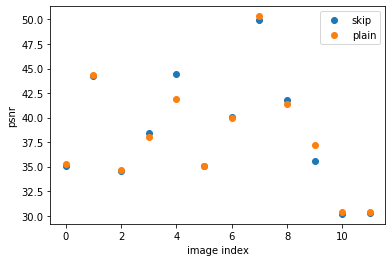

In [14]:
plt.plot(skip_psnr,"o",label="skip")
plt.plot(plain_psnr,"o",label="plain")
plt.xlabel("image index")
plt.ylabel("psnr")
plt.legend()
plt.show()

### Visualize Skipnet Activations and Output for the Last Image

##### skip deep decoder representation for the input image

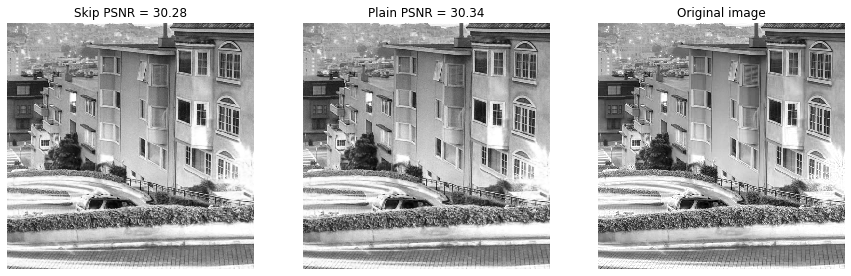

In [17]:
plot_size = (15,15)

### plot skip output
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(data_np[-1])
plt.subplot(131)
myimgshow(plt,out_img_np,plot_size = plot_size)
plt.title("Skip PSNR = {}".format( round(psnr(data_np[-1],out_img_np,maxv),2) ))
plt.axis('off')

### plot plain output
out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
plt.subplot(132)
myimgshow(plt,out_img_np,plot_size = plot_size)
plt.title("Plain PSNR = {}".format( round(psnr(data_np[-1],out_img_np,maxv),2) ))
plt.axis('off')

### plot origial image
plt.subplot(133)
myimgshow(plt,data_np[-1],plot_size = plot_size)
plt.axis('off')
plt.title("Original image")
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

In [18]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=1):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

##### individual channels per layer

output up to block4: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


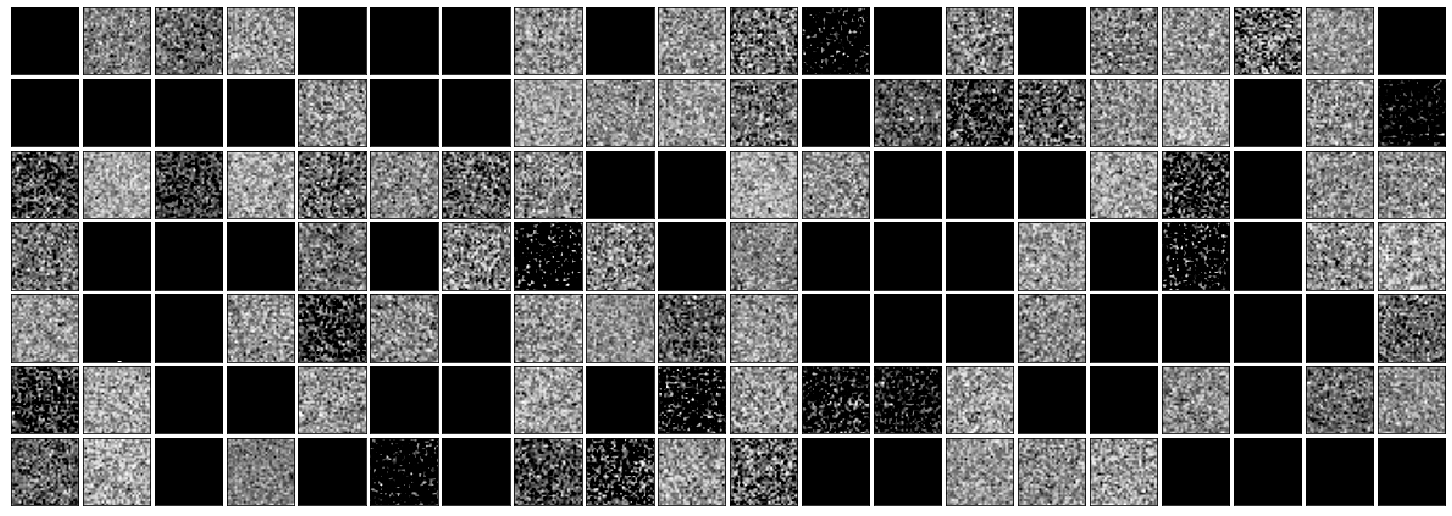

output up to block8: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


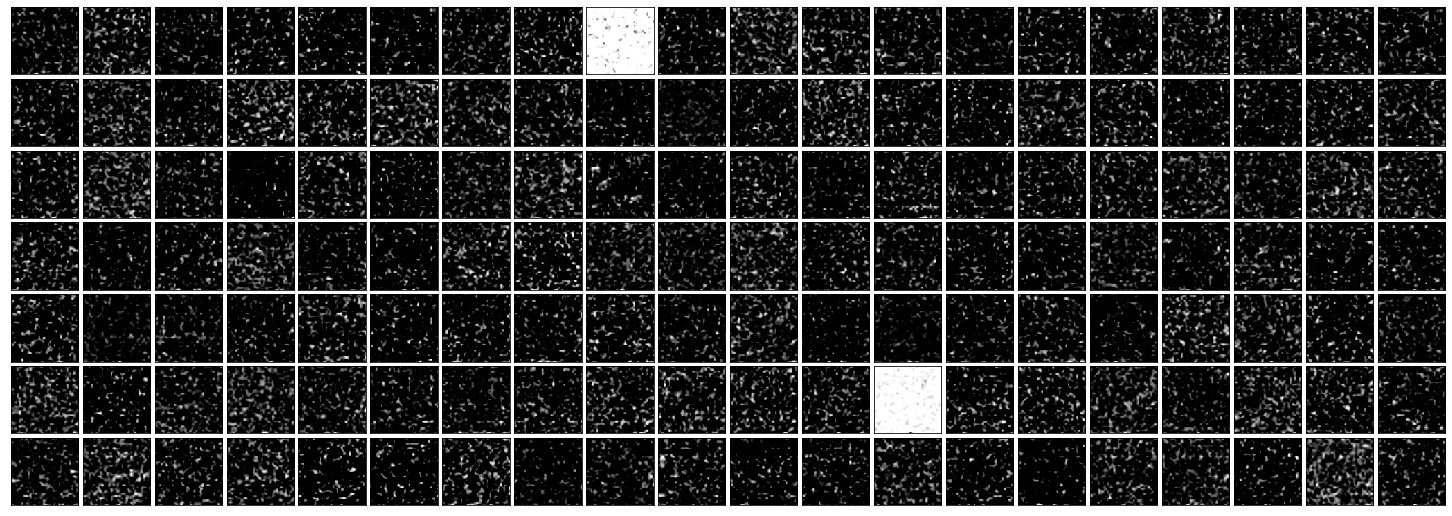

output up to block12: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


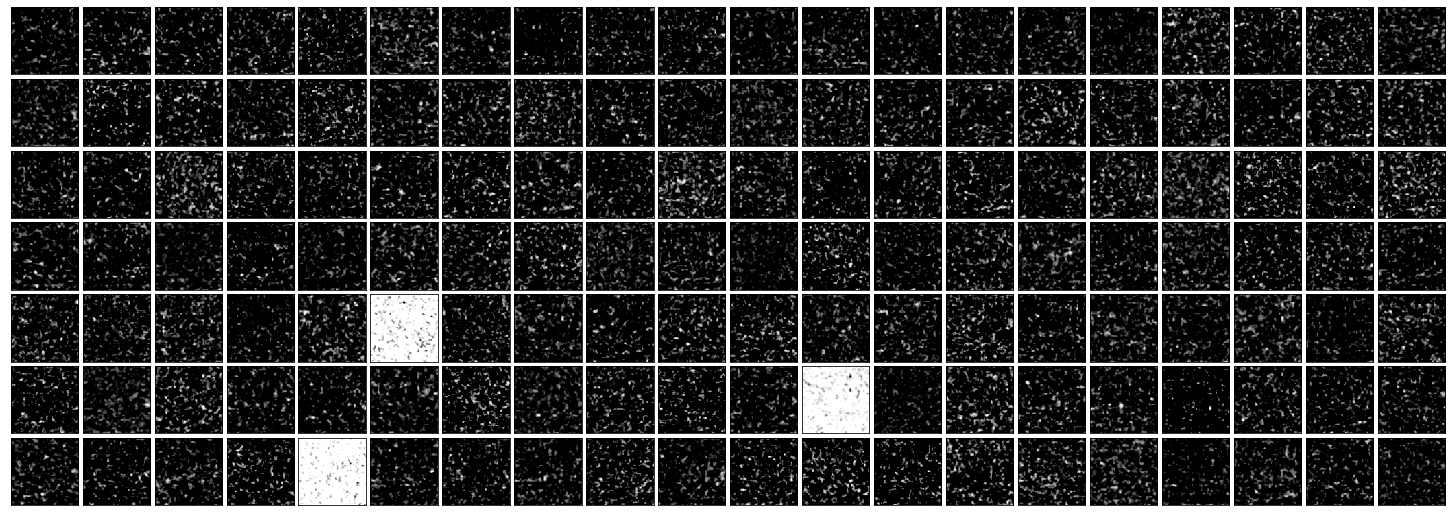

output up to block16: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


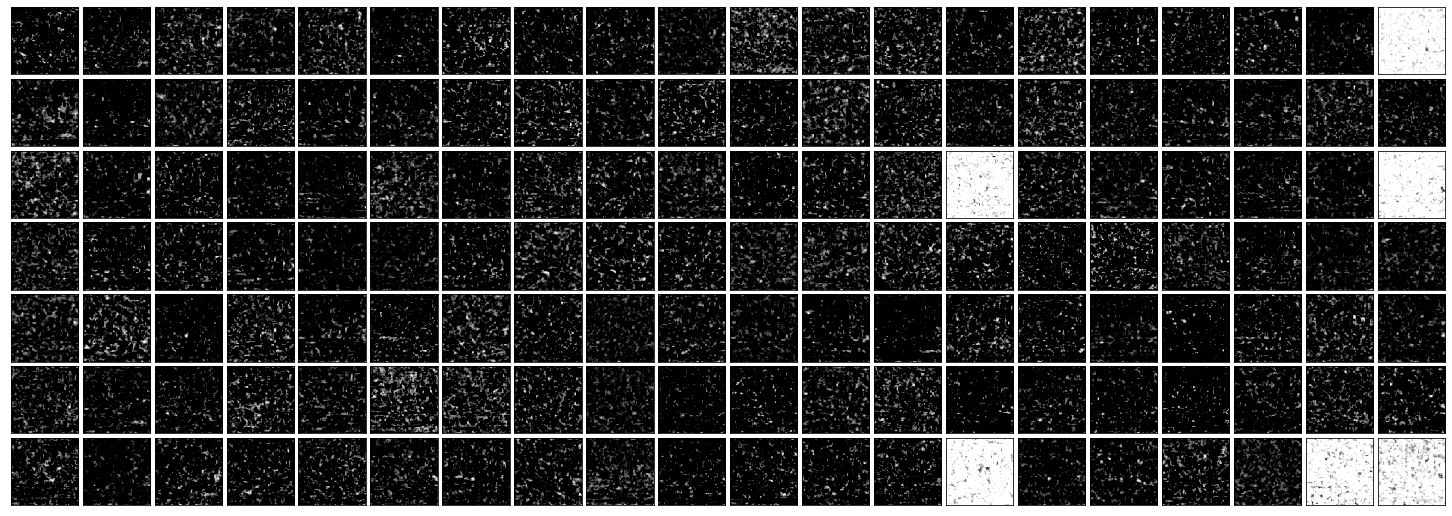

output up to block20: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


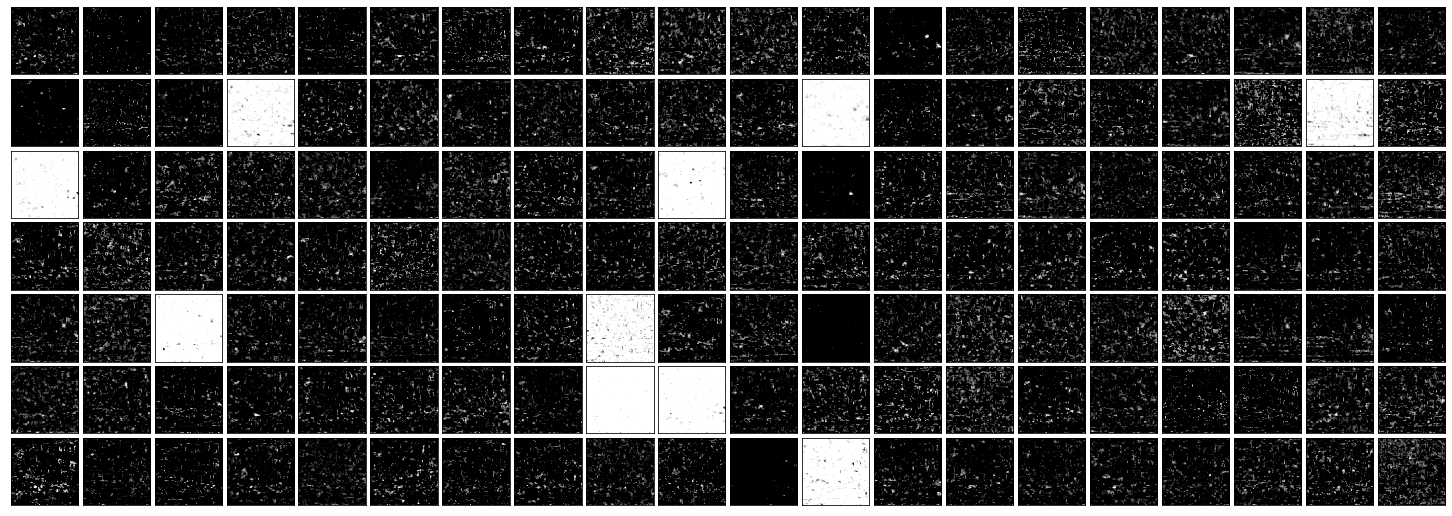

In [20]:
intermed_layers = skipnet.layer_inds + [skipnet.layer_inds[-1]+(skipnet.layer_inds[-1]-skipnet.layer_inds[-2])] # concat the index of the last layer before the combining layer manually

for n in intermed_layers:
        out = apply_until(skipni,skipnet.net1,n)
        plot_tensor(out,nrows=7)

##### mean over channels per layer

layer4
output up to block4: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


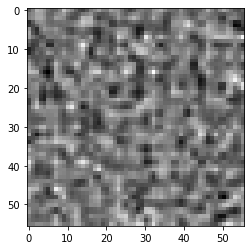

layer8
output up to block8: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


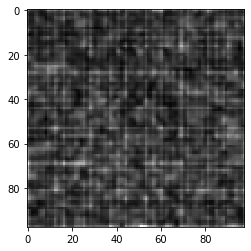

layer12
output up to block12: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


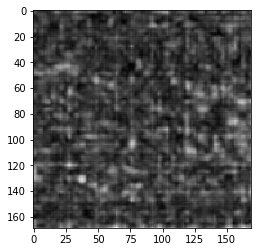

layer16
output up to block16: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


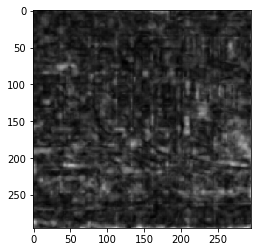

layer20
output up to block20: BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


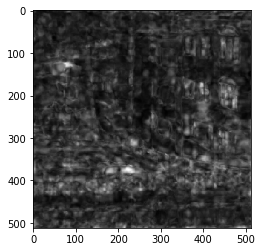

In [22]:
plt.rcParams["figure.figsize"] = (4,4)
for n in intermed_layers:
    print("layer{}".format(n))
    out = apply_until(skipni,skipnet.net1,n)
    plt.imshow(out.mean(1)[0].data.cpu())
    plt.show()

# Draft

In [3]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=1):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

### simple test

##### generate a random image

shape:  [1, 1, 16, 16]


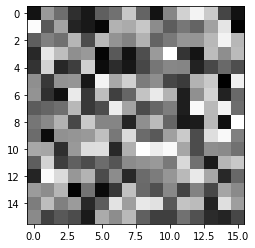

In [38]:
in_size = [4,4] # size of network input
num_channels = 6 # number of input channels (and also number of channels per layer)
out_size = [16,16] # size of original image
output_depth = 1 # number of channels in the original image
num_layers = 4

width = out_size[0]
height = out_size[1]
shape = [1,output_depth, width, height]
print("shape: ", shape)
img_var = Variable(torch.zeros(shape))
img_var.data.uniform_()
img_var.data *= 1./10
img_var = img_var.type(dtype)

myimgshow(plt,img_var[0].cpu())

##### create a skip network

In [39]:
skipnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=True).type(dtype)
print("number of skipnet params:", num_param(skipnet))

number of skipnet params: 162


In [40]:
skipnet

skip_model(
  (act_fun): ReLU()
  (sig): Sigmoid()
  (net1): Sequential(
    (1): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Upsample(size=(7, 7), mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): Upsample(size=(11, 11), mode=bilinear)
    (7): ReLU()
    (8): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): Upsample(size=[16, 16], mode=bilinear)
    (11): ReLU()
    (12): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (net2): Sequential(
    (1): Conv2d(18, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Sigmoid()
  )
)

##### fit the skipnet to the original image

In [41]:
rnd = 500
numit = 10000
rn = 0.001
maxv = np.max(np.array(img_var[0].cpu()))
mse_n, mse_t, skipni, skipnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=1e-2,
                            img_noisy_var=img_var,
                            net=skipnet,
                            img_clean_var=img_var,
                            find_best=True,
                            )
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]

shape:  [1, 6, 4, 4]
optimize with adam 0.01


##### individual channels per layer (before and after upsampling)

output up to block4: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


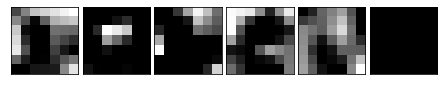

its upsampled version before feeding to the last layer


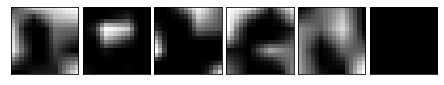



output up to block8: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


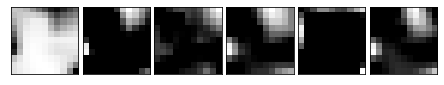

its upsampled version before feeding to the last layer


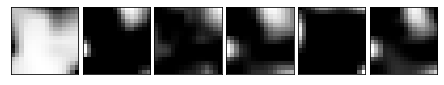



output up to block12: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


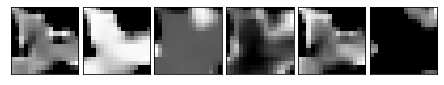

In [42]:
intermed_layers = skipnet.layer_inds + [skipnet.layer_inds[-1]+4] # concat the index of the last layer before the combining layer manually
intermed_upsampled = [skipnet.combinations[:,num_channels*i:num_channels*(i+1),:,:] for i in range(num_layers-1)] # this contains inputs of the last layer (i.e., upsampled versions of previous layers' outputs)
for i,n in enumerate(intermed_layers):
        out = apply_until(skipni,skipnet.net1,n)
        plot_tensor(out)
        if n != intermed_layers[-1]:
            print("its upsampled version before feeding to the last layer")
            plot_tensor(intermed_upsampled[i])
        print('\n')

##### skipnet representation ofthe image

Skip-Deep-Decoder representation of the image, SNR: 14.622565887116425


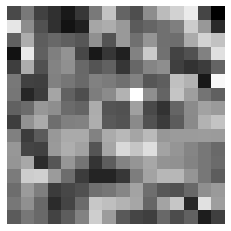

In [43]:
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
print("Skip-Deep-Decoder representation of the image, SNR: " + str(psnr(img_var[0].data.cpu().numpy(),out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()

##### original image

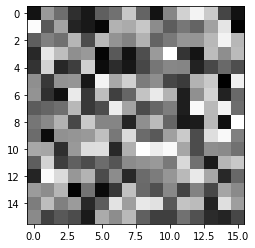

In [44]:
myimgshow(plt,img_var[0].cpu())